In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fetal-health-classification/fetal_health.csv


<a id="1"></a> <br>
# 1. Import Necessary Libraries

In [2]:
def warn(*args,**kwargs):
    pass
import warnings
warnings.warn = warn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold,RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, precision_recall_fscore_support,roc_auc_score,classification_report
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ROCAUC

<a id="1"></a> <br>
# 2. Import Dataset

In [3]:
data = pd.read_csv('/kaggle/input/fetal-health-classification/fetal_health.csv')

<a id="1"></a> <br>
# 3. EDA

In [4]:
data.fetal_health.value_counts()

1.0    1655
2.0     295
3.0     176
Name: fetal_health, dtype: int64

In [5]:
df_nunique = pd.DataFrame([[i, data[i].nunique()] for i in data.columns],columns=['column','nunique']).set_index('column')

In [6]:
df_nunique

,nunique
column,
baseline value,48
accelerations,20
fetal_movement,102
uterine_contractions,16
light_decelerations,16
severe_decelerations,2
prolongued_decelerations,6
abnormal_short_term_variability,75
mean_value_of_short_term_variability,57


In [7]:
data.describe()

,baseline value,accelerations,fetal_movement,uterine_contractions,light_decelerations,severe_decelerations,prolongued_decelerations,abnormal_short_term_variability,mean_value_of_short_term_variability,percentage_of_time_with_abnormal_long_term_variability,...,histogram_min,histogram_max,histogram_number_of_peaks,histogram_number_of_zeroes,histogram_mode,histogram_mean,histogram_median,histogram_variance,histogram_tendency,fetal_health
count,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.00000,...,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000,2126.000000
mean,133.303857,0.003178,0.009481,0.004366,0.001889,0.000003,0.000159,46.990122,1.332785,9.84666,...,93.579492,164.025400,4.068203,0.323612,137.452023,134.610536,138.090310,18.808090,0.320320,1.304327
std,9.840844,0.003866,0.046666,0.002946,0.002960,0.000057,0.000590,17.192814,0.883241,18.39688,...,29.560212,17.944183,2.949386,0.706059,16.381289,15.593596,14.466589,28.977636,0.610829,0.614377
min,106.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,12.000000,0.200000,0.00000,...,50.000000,122.000000,0.000000,0.000000,60.000000,73.000000,77.000000,0.000000,-1.000000,1.000000
25%,126.000000,0.000000,0.000000,0.002000,0.000000,0.000000,0.000000,32.000000,0.700000,0.00000,...,67.000000,152.000000,2.000000,0.000000,129.000000,125.000000,129.000000,2.000000,0.000000,1.000000
50%,133.000000,0.002000,0.000000,0.004000,0.000000,0.000000,0.000000,49.000000,1.200000,0.00000,...,93.000000,162.000000,3.000000,0.000000,139.000000,136.000000,139.000000,7.000000,0.000000,1.000000
75%,140.000000,0.006000,0.003000,0.007000,0.003000,0.000000,0.000000,61.000000,1.700000,11.00000,...,120.000000,174.000000,6.000000,0.000000,148.000000,145.000000,148.000000,24.000000,1.000000,1.000000
max,160.000000,0.019000,0.481000,0.015000,0.015000,0.001000,0.005000,87.000000,7.000000,91.00000,...,159.000000,238.000000,18.000000,10.000000,187.000000,182.000000,186.000000,269.000000,1.000000,3.000000


In [8]:
data1 = data.copy()
data1.fetal_health = data1.fetal_health.astype('int')
data1.fetal_health = data1.fetal_health.replace([1,2,3],['Normal','Suspect','Pathological'])

([<matplotlib.patches.Wedge at 0x7f0a764f81d0>,
 [Text(-0.8441562311892146, 0.7052660897451555, 'Normal'),
  Text(0.6344062353380878, -0.8986260226390926, 'Suspect'),
  Text(1.0630076905865578, -0.28286860863983, 'Pathological')],
 [Text(-0.4604488533759351, 0.38469059440644837, '78%'),
  Text(0.3460397647298661, -0.4901596487122323, '14%'),
  Text(0.5798223766835768, -0.15429196834899814, '8%')])

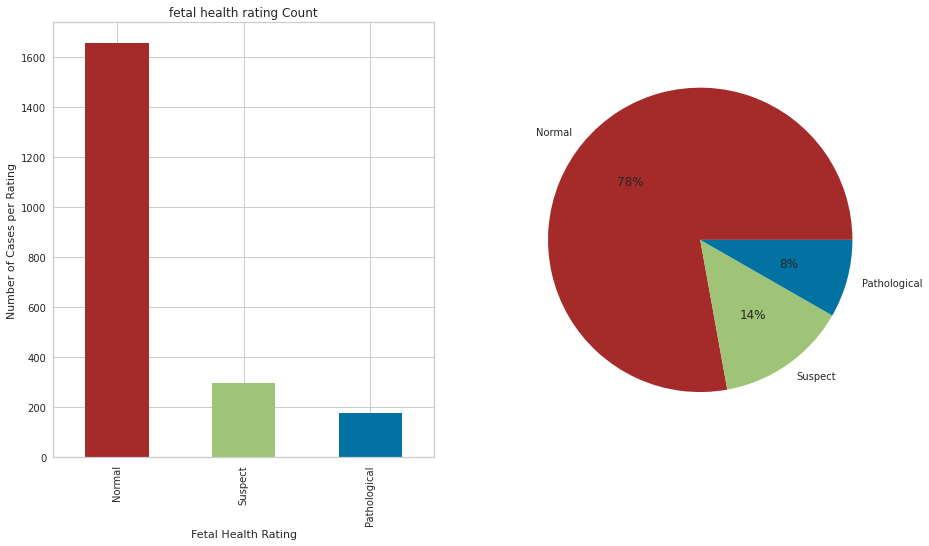

In [9]:
plt.figure(figsize=(15,8))
plt.subplot(121)
data1.fetal_health.value_counts().plot(kind='bar',figsize=(15,8),color = ['brown','g','b'])
plt.title('fetal health rating Count')
plt.xlabel('Fetal Health Rating')
plt.ylabel('Number of Cases per Rating')

plt.subplot(122)
plt.pie(data1.fetal_health.value_counts(),labels=[
    'Normal', 'Suspect', 'Pathological'], colors = ['brown', 'g', 'b'], autopct='%1.0f%%')

<a id="1"></a> <br>
# 4. Define Functions

In [10]:
# Split Data Function:
def split_data (X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y, stratify = y,test_size=0.2,random_state=42)
    return X_train,X_test,y_train,y_test

# Calculate metrics Function:
def calculate_metrics(y_t,y_p,label): 
    acc_score = accuracy_score(y_t,y_p)
    precision, recall, f_score, support = precision_recall_fscore_support(y_t,y_p,average='weighted')
    data = {label:[acc_score,precision,recall,f_score]}
    df = pd.DataFrame(data,index=['accuracy_score','precision','recall','f1_score'])
    return df

# Calculate Classification Report Function:
def class_report(y_t,y_p):
    return print('Classification Report: {}'.format(classification_report(y_t,y_p)))

# GridSearchCV Function:
def grid_search (X_train,y_train,X_test,params_grid,model):
    cv = RepeatedStratifiedKFold(n_splits=3, n_repeats=5, random_state=42)
    grid_search = GridSearchCV(model , param_grid = params_grid, cv = cv, scoring='accuracy',verbose=1)
    grid_search.fit(X_train,y_train)
    y_pred = grid_search.predict(X_test)
    best_params = grid_search.best_params_
    best_estimtor = grid_search.best_estimator_
    return best_params,best_estimtor,y_pred

# Smote Function:
def SMOTE_f(X_train,y_train):
    sm = SMOTE(random_state=42)
    X_train_smo, y_train_smo = sm.fit_resample(X_train,y_train)
    return X_train_smo, y_train_smo

def cross_val_score_f(model,X_train,y_train,label):
    cv = StratifiedKFold(n_splits=3,shuffle=True, random_state=42)
    scores = cross_val_score(model,X_train,y_train,cv = cv, scoring='accuracy')
    data = {label:[round(scores.mean(),3),round(scores.std(),3)]}
    df = pd.DataFrame(data , index=['Scores_Mean','Scores_Std'])
    return df

<a id="1"></a> <br>
# 5. Train/Test Split

In [11]:
X = data.drop('fetal_health',axis=1)
y = data.fetal_health
X_train,X_test,y_train,y_test = split_data (X,y)

<a id="1"></a> <br>
# 6. Scaling Data

In [12]:
SS = StandardScaler()
SS.fit(X_train)
X_train = pd.DataFrame(data = SS.transform(X_train), columns = X.columns)
X_test = pd.DataFrame(data = SS.transform(X_test), columns = X.columns)

<a id="1"></a> <br>
# 7. Modeling

**Logistic Regression**

In [13]:
lr = LogisticRegression(multi_class = 'multinomial', random_state=42)
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
df = calculate_metrics(y_test,y_pred,'lr')

In [14]:
df

,lr
accuracy_score,0.884977
precision,0.889293
recall,0.884977
f1_score,0.885471


In [15]:
lr_acc = df.loc['accuracy_score','lr']
lr_precision = df.loc['precision','lr']
lr_recall = df.loc['recall','lr']
lr_f1 = df.loc['f1_score','lr']

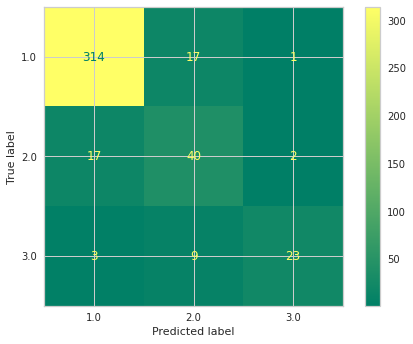

In [16]:
plot_confusion_matrix(lr,X_test,y_test,colorbar=True,cmap='summer')

In [17]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.94      0.95      0.94       332
         2.0       0.61      0.68      0.64        59
         3.0       0.88      0.66      0.75        35

    accuracy                           0.88       426
   macro avg       0.81      0.76      0.78       426
weighted avg       0.89      0.88      0.89       426



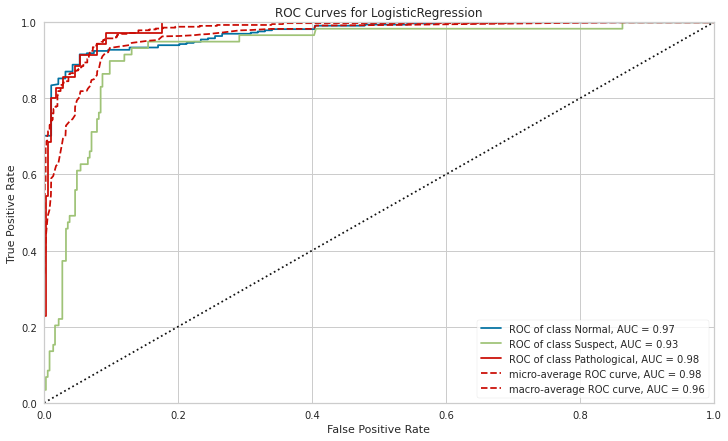

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [18]:
classes = ['Normal', 'Suspect', 'Pathological']
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(lr, classes=classes, ax=ax)
roc.fit(X_train, y_train)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**Synthetic Minority Oversampling TEchnique (SMOTE) Logistic Regression**

In [19]:
X_train_smo, y_train_smo = SMOTE_f(X_train,y_train)

In [20]:
lr_SMOTE = LogisticRegression(multi_class = 'multinomial', random_state=42)
lr_SMOTE.fit(X_train_smo,y_train_smo)
y_pred = lr.predict(X_test)
df = calculate_metrics(y_test,y_pred,'lr_SMOTE')

In [21]:
df

,lr_SMOTE
accuracy_score,0.884977
precision,0.889293
recall,0.884977
f1_score,0.885471


In [22]:
lr_SMOTE_acc = df.loc['accuracy_score','lr_SMOTE']
lr_SMOTE_precision = df.loc['precision','lr_SMOTE']
lr_SMOTE_recall = df.loc['recall','lr_SMOTE']
lr_SMOTE_f1 = df.loc['f1_score','lr_SMOTE']

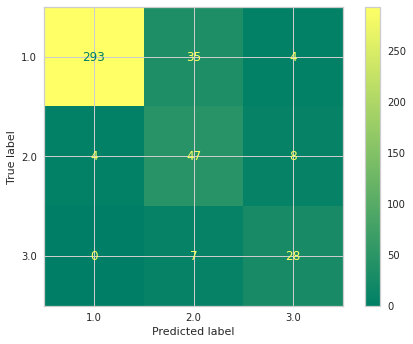

In [23]:
plot_confusion_matrix(lr_SMOTE,X_test,y_test,colorbar=True,cmap='summer')

In [24]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.94      0.95      0.94       332
         2.0       0.61      0.68      0.64        59
         3.0       0.88      0.66      0.75        35

    accuracy                           0.88       426
   macro avg       0.81      0.76      0.78       426
weighted avg       0.89      0.88      0.89       426



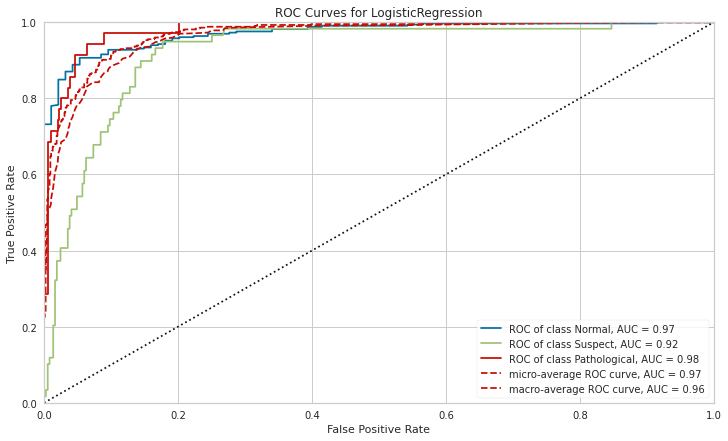

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [25]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(lr_SMOTE, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**GridSerachCV - SMOTE Logistic Regression**

In [26]:
params_grid = {'C':range(10,150,10),
              'penalty':['l1','l2']}
best_params,best_estimtor,y_pred = grid_search (X_train_smo,y_train_smo,X_test,params_grid,lr_SMOTE)

Fitting 15 folds for each of 28 candidates, totalling 420 fits


In [27]:
best_params , best_estimtor

({'C': 40, 'penalty': 'l2'},
 LogisticRegression(C=40, multi_class='multinomial', random_state=42))

In [28]:
GridSerachCV_lr = best_estimtor
df = calculate_metrics(y_test,y_pred,'GridSerachCV_lr')

In [29]:
df

,GridSerachCV_lr
accuracy_score,0.863850
precision,0.900187
recall,0.863850
f1_score,0.875537


In [30]:
GridSerachCV_lr_acc = df.loc['accuracy_score','GridSerachCV_lr']
GridSerachCV_lr_precision = df.loc['precision','GridSerachCV_lr']
GridSerachCV_lr_recall = df.loc['recall','GridSerachCV_lr']
GridSerachCV_lr_f1 = df.loc['f1_score','GridSerachCV_lr']

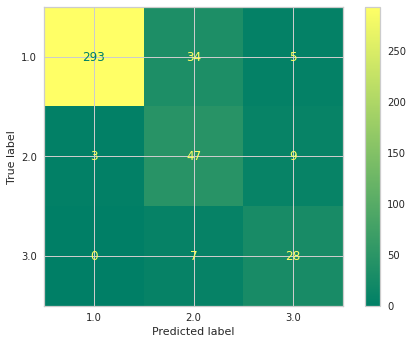

In [31]:
plot_confusion_matrix(GridSerachCV_lr,X_test,y_test,colorbar=True,cmap='summer')

In [32]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.99      0.88      0.93       332
         2.0       0.53      0.80      0.64        59
         3.0       0.67      0.80      0.73        35

    accuracy                           0.86       426
   macro avg       0.73      0.83      0.77       426
weighted avg       0.90      0.86      0.88       426



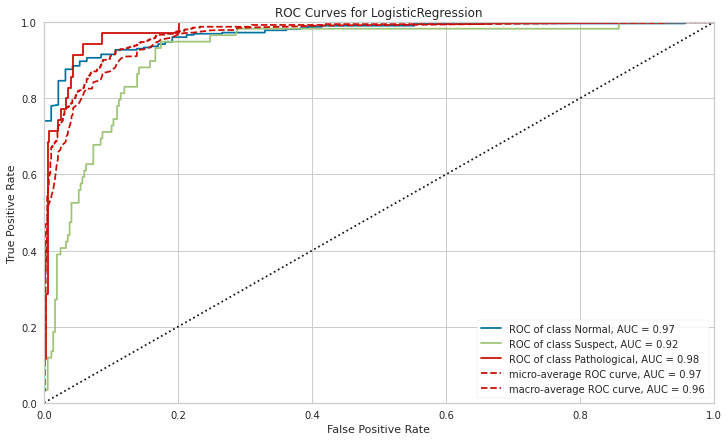

<AxesSubplot:title={'center':'ROC Curves for LogisticRegression'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [33]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(GridSerachCV_lr, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**SMOTE KNN**

In [34]:
knn = KNeighborsClassifier()
knn.fit(X_train_smo,y_train_smo)
y_pred = knn.predict(X_test)
df = calculate_metrics(y_test,y_pred,'knn')

In [35]:
df

,knn
accuracy_score,0.870892
precision,0.892207
recall,0.870892
f1_score,0.878650


In [36]:
knn_acc = df.loc['accuracy_score','knn']
knn_precision = df.loc['precision','knn']
knnr_recall = df.loc['recall','knn']
knn_f1 = df.loc['f1_score','knn']

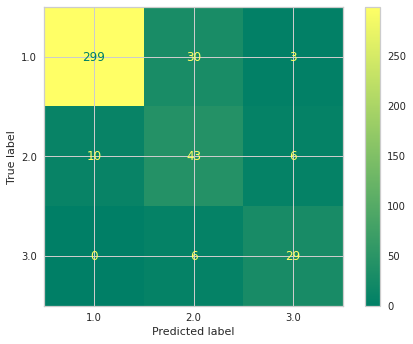

In [37]:
plot_confusion_matrix(knn,X_test,y_test,colorbar=True,cmap='summer')

In [38]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.97      0.90      0.93       332
         2.0       0.54      0.73      0.62        59
         3.0       0.76      0.83      0.79        35

    accuracy                           0.87       426
   macro avg       0.76      0.82      0.78       426
weighted avg       0.89      0.87      0.88       426



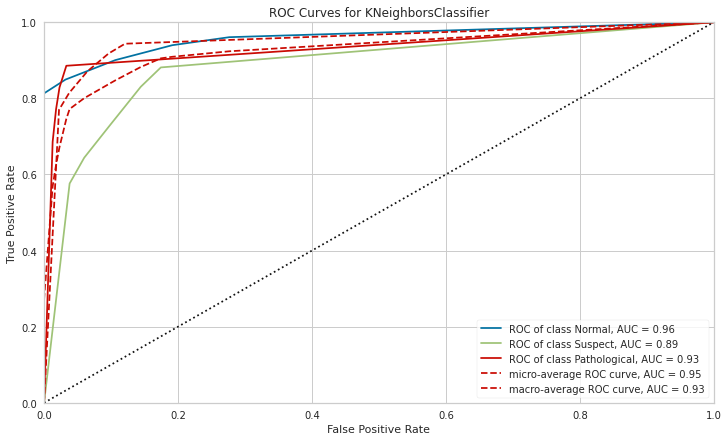

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [39]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(knn, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**GridSearchCV - SMOTE KNN**

In [40]:
params_grid = {'n_neighbors':range(3,21,2),
              'metric':['euclidean','manhattan']}
best_params,best_estimtor,y_pred = grid_search (X_train_smo,y_train_smo,X_test,params_grid,knn)

Fitting 15 folds for each of 18 candidates, totalling 270 fits


In [41]:
best_params,best_estimtor

({'metric': 'manhattan', 'n_neighbors': 3},
 KNeighborsClassifier(metric='manhattan', n_neighbors=3))

In [42]:
GridSearchCV_knn = best_estimtor
df = calculate_metrics(y_test,y_pred,'GridSearchCV_knn')

In [43]:
df

,GridSearchCV_knn
accuracy_score,0.887324
precision,0.905369
recall,0.887324
f1_score,0.893687


In [44]:
GridSearchCV_knn_acc = df.loc['accuracy_score','GridSearchCV_knn']
GridSearchCV_knn_precision = df.loc['precision','GridSearchCV_knn']
GridSearchCV_knn_recall = df.loc['recall','GridSearchCV_knn']
GridSearchCV_knn_f1 = df.loc['f1_score','GridSearchCV_knn']

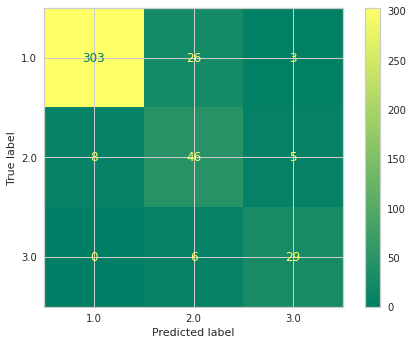

In [45]:
plot_confusion_matrix(GridSearchCV_knn,X_test,y_test,colorbar=True,cmap='summer')

In [46]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.97      0.91      0.94       332
         2.0       0.59      0.78      0.67        59
         3.0       0.78      0.83      0.81        35

    accuracy                           0.89       426
   macro avg       0.78      0.84      0.81       426
weighted avg       0.91      0.89      0.89       426



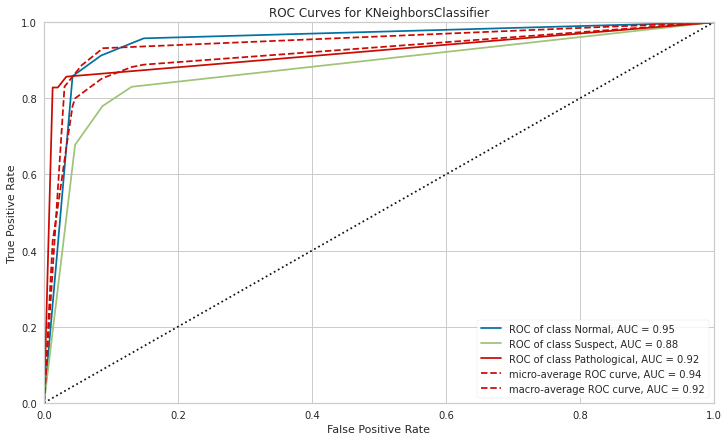

<AxesSubplot:title={'center':'ROC Curves for KNeighborsClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [47]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(GridSearchCV_knn, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**SMOTE Decision Tree**

In [48]:
decision_t = DecisionTreeClassifier(random_state=42)
decision_t.fit(X_train_smo, y_train_smo)
y_pred = decision_t.predict(X_test)
df = calculate_metrics(y_test,y_pred,'decision_t')

In [49]:
df

,decision_t
accuracy_score,0.903756
precision,0.898086
recall,0.903756
f1_score,0.899278


In [50]:
decision_t_acc = df.loc['accuracy_score','decision_t']
decision_t_precision = df.loc['precision','decision_t']
decision_t_recall = df.loc['recall','decision_t']
decision_t_f1 = df.loc['f1_score','decision_t']

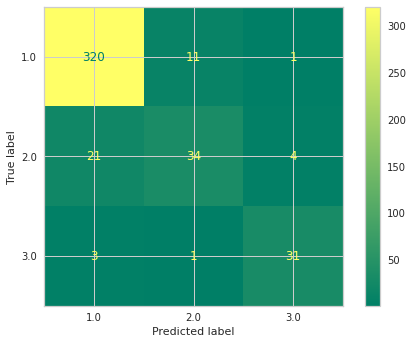

In [51]:
plot_confusion_matrix(decision_t,X_test,y_test,colorbar=True,cmap='summer')

In [52]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.93      0.96      0.95       332
         2.0       0.74      0.58      0.65        59
         3.0       0.86      0.89      0.87        35

    accuracy                           0.90       426
   macro avg       0.84      0.81      0.82       426
weighted avg       0.90      0.90      0.90       426



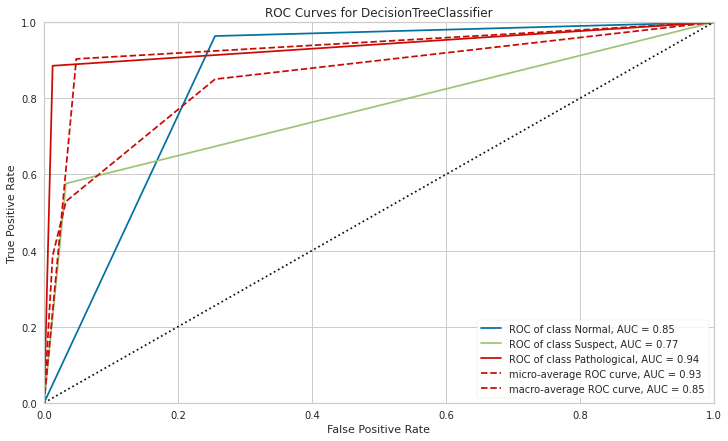

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [53]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(decision_t, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**GridSearchCV - SMOTE Decision Tree**

In [54]:
params_grid = {'max_depth':range(2,24,2),
               'min_samples_split': [2, 3, 4]}
best_params,best_estimtor,y_pred = grid_search (X_train_smo,y_train_smo,X_test,params_grid,decision_t)

Fitting 15 folds for each of 33 candidates, totalling 495 fits


In [55]:
best_params,best_estimtor

({'max_depth': 14, 'min_samples_split': 2},
 DecisionTreeClassifier(max_depth=14, random_state=42))

In [56]:
GridSearchCV_dt = best_estimtor
df = calculate_metrics(y_test,y_pred,'GridSearchCV_dt')

In [57]:
df

,GridSearchCV_dt
accuracy_score,0.901408
precision,0.895664
recall,0.901408
f1_score,0.897151


In [58]:
GridSearchCV_dt_acc = df.loc['accuracy_score','GridSearchCV_dt']
GridSearchCV_dt_precision = df.loc['precision','GridSearchCV_dt']
GridSearchCV_dt_recall = df.loc['recall','GridSearchCV_dt']
GridSearchCV_dt_f1 = df.loc['f1_score','GridSearchCV_dt']

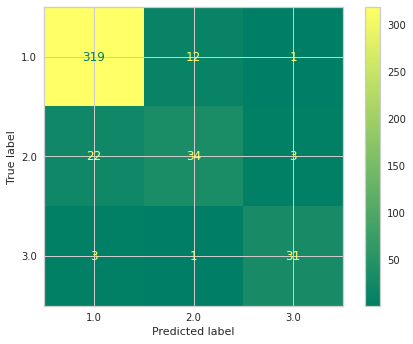

In [59]:
plot_confusion_matrix(GridSearchCV_dt,X_test,y_test,colorbar=True,cmap='summer')

In [60]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.93      0.96      0.94       332
         2.0       0.72      0.58      0.64        59
         3.0       0.89      0.89      0.89        35

    accuracy                           0.90       426
   macro avg       0.85      0.81      0.82       426
weighted avg       0.90      0.90      0.90       426



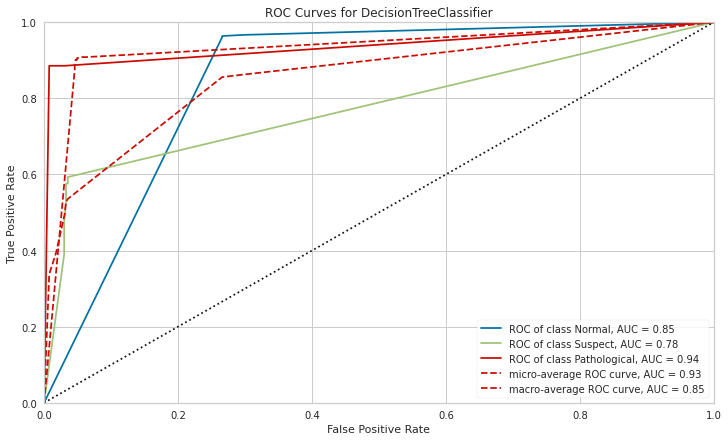

<AxesSubplot:title={'center':'ROC Curves for DecisionTreeClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [61]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(GridSearchCV_dt, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**SMOTE Random Forest**

In [62]:
RF = RandomForestClassifier(n_estimators = 100, random_state=42, n_jobs=-1)
RF.fit(X_train_smo,y_train_smo)
y_pred = RF.predict(X_test)
df = calculate_metrics(y_test,y_pred,'RF')

In [63]:
df

,RF
accuracy_score,0.920188
precision,0.920764
recall,0.920188
f1_score,0.920415


In [64]:
RF_acc = df.loc['accuracy_score','RF']
RF_precision = df.loc['precision','RF']
RF_recall = df.loc['recall','RF']
RF_f1 = df.loc['f1_score','RF']

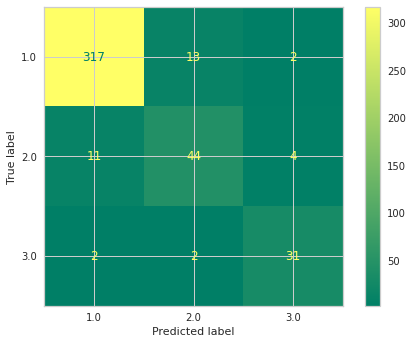

In [65]:
plot_confusion_matrix(RF,X_test,y_test,colorbar=True,cmap='summer')

In [66]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.96      0.95      0.96       332
         2.0       0.75      0.75      0.75        59
         3.0       0.84      0.89      0.86        35

    accuracy                           0.92       426
   macro avg       0.85      0.86      0.85       426
weighted avg       0.92      0.92      0.92       426



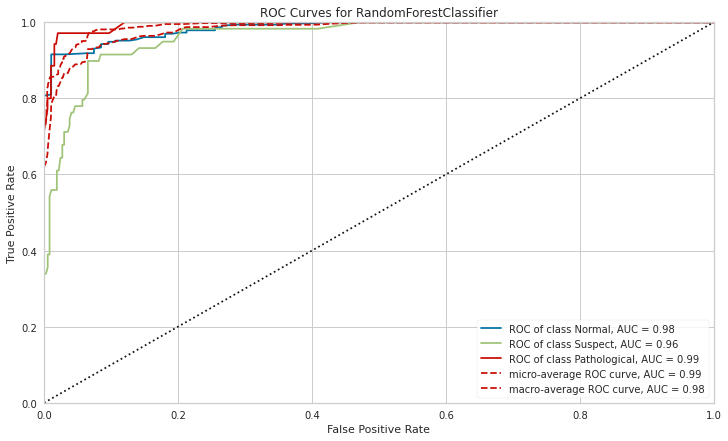

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [67]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(RF, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**SMOTE GridSearchCV - Random Forest**

In [68]:
params_grid = { 
    'n_estimators': [75, 100, 125],
    'max_features': [.25, .35, 'auto'],
    'max_depth' : [7, 9, 11],
    'criterion' : ['entropy']}
best_params,best_estimtor,y_pred = grid_search (X_train_smo,y_train_smo,X_test,params_grid,RF)

Fitting 15 folds for each of 27 candidates, totalling 405 fits


In [69]:
best_params,best_estimtor

({'criterion': 'entropy',
  'max_depth': 11,
  'max_features': 'auto',
  'n_estimators': 100},
 RandomForestClassifier(criterion='entropy', max_depth=11, n_jobs=-1,
                        random_state=42))

In [70]:
GridSearchCV_RF = best_estimtor
df = calculate_metrics(y_test,y_pred,'GridSearchCV_RF')

In [71]:
df

,GridSearchCV_RF
accuracy_score,0.927230
precision,0.929087
recall,0.927230
f1_score,0.928052


In [72]:
GridSearchCV_RF_acc = df.loc['accuracy_score','GridSearchCV_RF']
GridSearchCV_RF_precision = df.loc['precision','GridSearchCV_RF']
GridSearchCV_RF_recall = df.loc['recall','GridSearchCV_RF']
GridSearchCV_RF_f1 = df.loc['f1_score','GridSearchCV_RF']

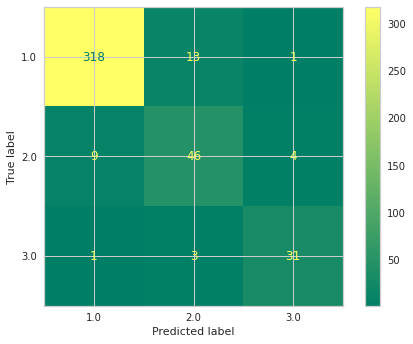

In [73]:
plot_confusion_matrix(GridSearchCV_RF,X_test,y_test,colorbar=True,cmap='summer')

In [74]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.97      0.96      0.96       332
         2.0       0.74      0.78      0.76        59
         3.0       0.86      0.89      0.87        35

    accuracy                           0.93       426
   macro avg       0.86      0.87      0.87       426
weighted avg       0.93      0.93      0.93       426



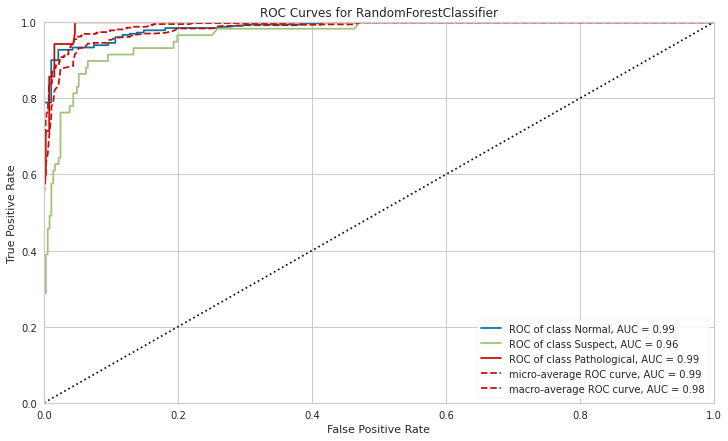

<AxesSubplot:title={'center':'ROC Curves for RandomForestClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [75]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(GridSearchCV_RF, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**SMOTE ADABoost**

In [76]:
ada_boost = AdaBoostClassifier(DecisionTreeClassifier(random_state=42), n_estimators=200,
                               learning_rate=0.01, random_state=42)
ada_boost.fit(X_train_smo,y_train_smo)
y_pred = ada_boost.predict(X_test)
df = calculate_metrics(y_test,y_pred,'ada_boost')

In [77]:
df

,ada_boost
accuracy_score,0.913146
precision,0.910969
recall,0.913146
f1_score,0.911824


In [78]:
ada_boost_acc = df.loc['accuracy_score','ada_boost']
ada_boost_precision = df.loc['precision','ada_boost']
ada_boost_recall = df.loc['recall','ada_boost']
ada_boost_f1 = df.loc['f1_score','ada_boost']

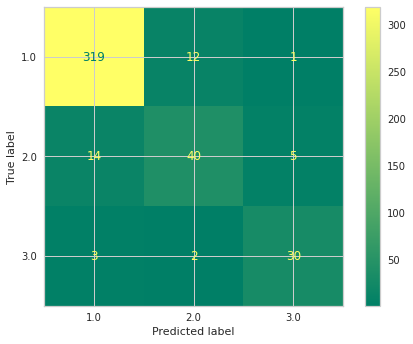

In [79]:
plot_confusion_matrix(ada_boost,X_test,y_test,colorbar=True,cmap='summer')

In [80]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.95      0.96      0.96       332
         2.0       0.74      0.68      0.71        59
         3.0       0.83      0.86      0.85        35

    accuracy                           0.91       426
   macro avg       0.84      0.83      0.84       426
weighted avg       0.91      0.91      0.91       426



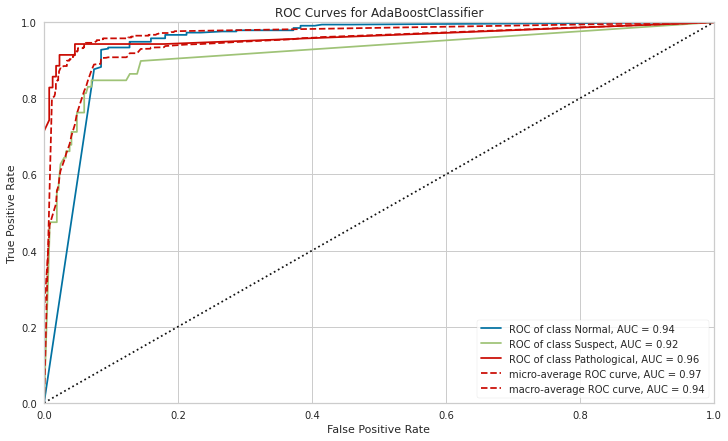

<AxesSubplot:title={'center':'ROC Curves for AdaBoostClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [81]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(ada_boost, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

**SMOTE VotingClassifier**

In [82]:
Voting_C = VotingClassifier(estimators = [('lr',lr),('lr_SMOTE',lr_SMOTE),
                                        ('GridSerachCV_lr',GridSerachCV_lr),
                                        ('knn',knn),('GridSearchCV_knn',GridSearchCV_knn),
                                        ('decision_t',decision_t),('GridSearchCV_dt',GridSearchCV_dt),
                                        ('RF',RF),('GridSearchCV_RF',GridSearchCV_RF),
                                        ('ada_boost',ada_boost)], voting='soft',n_jobs=-1)
Voting_C.fit(X_train_smo,y_train_smo)
y_pred = Voting_C.predict(X_test)
df = calculate_metrics(y_test,y_pred,'Voting_C')

In [83]:
df

,Voting_C
accuracy_score,0.917840
precision,0.920809
recall,0.917840
f1_score,0.919098


In [84]:
Voting_C_acc = df.loc['accuracy_score','Voting_C']
Voting_C_precision = df.loc['precision','Voting_C']
Voting_C_recall = df.loc['recall','Voting_C']
Voting_C_f1 = df.loc['f1_score','Voting_C']

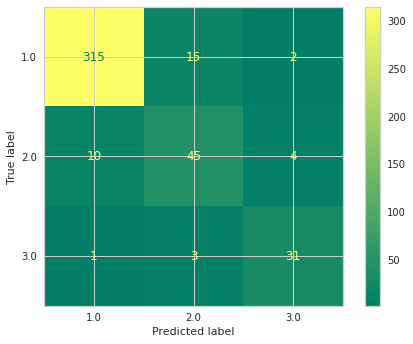

In [85]:
plot_confusion_matrix(Voting_C,X_test,y_test,colorbar=True,cmap='summer')

In [86]:
class_report(y_test,y_pred)

Classification Report:               precision    recall  f1-score   support

         1.0       0.97      0.95      0.96       332
         2.0       0.71      0.76      0.74        59
         3.0       0.84      0.89      0.86        35

    accuracy                           0.92       426
   macro avg       0.84      0.87      0.85       426
weighted avg       0.92      0.92      0.92       426



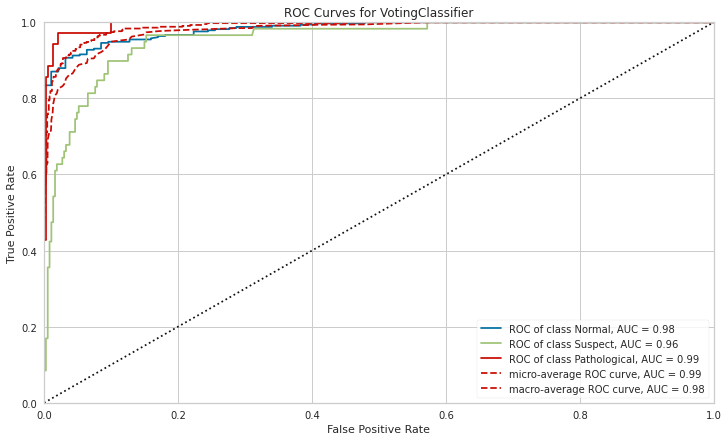

<AxesSubplot:title={'center':'ROC Curves for VotingClassifier'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [87]:
fig, ax = plt.subplots(figsize=(12, 7))
roc = ROCAUC(Voting_C, classes=classes, ax=ax)
roc.fit(X_train_smo, y_train_smo)        # Fit the training data to the visualizer
roc.score(X_test, y_test)        # Evaluate the model on the test data
roc.show()

<a id="1"></a> <br>
# 8. Model Comparison

**Accuracy Score**

In [88]:
accuracy_result = pd.DataFrame({'Model':['Logistic Regression','SMOTE Logistic Regression',
                                        'GridSerachCV SMOTE Logistic Regression',
                                        'SMOTE KNN','GridSerachCV SMOTE KNN',
                                        'SMOTE Decision Tree','GridSerachCV SMOTE Decision Tree',
                                        'SMOTE Random Forest','GridSerachCV SMOTE Random Forest',
                                        'SMOTE Ada Boost','SMOTE Voting_C'],
                                'Accuracy_Score':[lr_acc,lr_SMOTE_acc,GridSerachCV_lr_acc,knn_acc,GridSearchCV_knn_acc,
                                                 decision_t_acc,GridSearchCV_dt_acc,RF_acc,GridSearchCV_RF_acc,ada_boost_acc,
                                                 Voting_C_acc]})
accuracy_result = accuracy_result.sort_values(by = 'Accuracy_Score',ascending=False)
accuracy_result = accuracy_result.set_index('Accuracy_Score')
accuracy_result

,Model
Accuracy_Score,
0.927230,GridSerachCV SMOTE Random Forest
0.920188,SMOTE Random Forest
0.917840,SMOTE Voting_C
0.913146,SMOTE Ada Boost
0.903756,SMOTE Decision Tree
0.901408,GridSerachCV SMOTE Decision Tree
0.887324,GridSerachCV SMOTE KNN
0.884977,Logistic Regression
0.884977,SMOTE Logistic Regression


**Recall Score**

In [89]:
recall_result = pd.DataFrame({'Model':['Logistic Regression','SMOTE Logistic Regression',
                                        'GridSerachCV SMOTE Logistic Regression',
                                        'SMOTE KNN','GridSerachCV SMOTE KNN',
                                        'SMOTE Decision Tree','GridSerachCV SMOTE Decision Tree',
                                        'SMOTE Random Forest','GridSerachCV SMOTE Random Forest',
                                        'SMOTE Ada Boost','SMOTE Voting_C'],
                                'recall_Score':[lr_recall,lr_SMOTE_recall,GridSerachCV_lr_recall,knnr_recall,GridSearchCV_knn_recall,
                                                 decision_t_recall,GridSearchCV_dt_recall,RF_recall,GridSearchCV_RF_recall,ada_boost_recall,
                                                 Voting_C_recall]})
recall_result = recall_result.sort_values(by = 'recall_Score',ascending=False)
recall_result = recall_result.set_index('recall_Score')
recall_result

,Model
recall_Score,
0.927230,GridSerachCV SMOTE Random Forest
0.920188,SMOTE Random Forest
0.917840,SMOTE Voting_C
0.913146,SMOTE Ada Boost
0.903756,SMOTE Decision Tree
0.901408,GridSerachCV SMOTE Decision Tree
0.887324,GridSerachCV SMOTE KNN
0.884977,Logistic Regression
0.884977,SMOTE Logistic Regression


**F1 Score**

In [90]:
f1_result = pd.DataFrame({'Model':['Logistic Regression','SMOTE Logistic Regression',
                                        'GridSerachCV SMOTE Logistic Regression',
                                        'SMOTE KNN','GridSerachCV SMOTE KNN',
                                        'SMOTE Decision Tree','GridSerachCV SMOTE Decision Tree',
                                        'SMOTE Random Forest','GridSerachCV SMOTE Random Forest',
                                        'SMOTE Ada Boost','SMOTE Voting_C'],
                                'f1_Score':[lr_f1,lr_SMOTE_f1,GridSerachCV_lr_f1,knn_f1,GridSearchCV_knn_f1,
                                                 decision_t_f1,GridSearchCV_dt_f1,RF_f1,GridSearchCV_RF_f1,ada_boost_f1,
                                                 Voting_C_f1]})
f1_result = f1_result.sort_values(by = 'f1_Score',ascending=False)
f1_result = f1_result.set_index('f1_Score')
f1_result

,Model
f1_Score,
0.928052,GridSerachCV SMOTE Random Forest
0.920415,SMOTE Random Forest
0.919098,SMOTE Voting_C
0.911824,SMOTE Ada Boost
0.899278,SMOTE Decision Tree
0.897151,GridSerachCV SMOTE Decision Tree
0.893687,GridSerachCV SMOTE KNN
0.885471,Logistic Regression
0.885471,SMOTE Logistic Regression


**Precision Score**

In [91]:
Precision_result = pd.DataFrame({'Model':['Logistic Regression','SMOTE Logistic Regression',
                                        'GridSerachCV SMOTE Logistic Regression',
                                        'SMOTE KNN','GridSerachCV SMOTE KNN',
                                        'SMOTE Decision Tree','GridSerachCV SMOTE Decision Tree',
                                        'SMOTE Random Forest','GridSerachCV SMOTE Random Forest',
                                        'SMOTE Ada Boost','SMOTE Voting_C'],
                                'Precision_Score':[lr_precision,lr_SMOTE_precision,GridSerachCV_lr_precision,knn_precision,GridSearchCV_knn_precision,
                                                 decision_t_precision,GridSearchCV_dt_precision,RF_precision,GridSearchCV_RF_precision,ada_boost_precision,
                                                 Voting_C_precision]})
Precision_result = Precision_result.sort_values(by = 'Precision_Score',ascending=False)
Precision_result = Precision_result.set_index('Precision_Score')
Precision_result

,Model
Precision_Score,
0.929087,GridSerachCV SMOTE Random Forest
0.920809,SMOTE Voting_C
0.920764,SMOTE Random Forest
0.910969,SMOTE Ada Boost
0.905369,GridSerachCV SMOTE KNN
0.900187,GridSerachCV SMOTE Logistic Regression
0.898086,SMOTE Decision Tree
0.895664,GridSerachCV SMOTE Decision Tree
0.892207,SMOTE KNN
